In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2

In [2]:
#Model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall,Recall
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [3]:
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
# LOAD DATA
path = "C:\\Users\\kumar\\Desktop\\Avatar_Assignment\\COVID-19_Radiography_Dataset"

diag_code_dict = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3}

diag_title_dict = {
    'COVID': 'Covid-19',
    'Lung_Opacity': 'Lung Opacity',
    'Normal': 'Healthy',
    'Viral Pneumonia': 'Viral Pneumonia'}
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(path, '*','*.png'))}

covidData = pd.DataFrame.from_dict(imageid_path_dict, orient = 'index').reset_index()
covidData.columns = ['image_id','path']
classes = covidData.image_id.str.split('-').str[0]
covidData['diag'] = classes
covidData['target'] = covidData['diag'].map(diag_code_dict.get) 
covidData['Class'] = covidData['diag'].map(diag_title_dict.get)

In [5]:
covidData.Class.unique()

array(['Covid-19', 'Lung Opacity', 'Healthy', 'Viral Pneumonia'],
      dtype=object)

In [6]:
covidData.head()

,image_id,path,diag,target,Class
0,COVID-1,C:\Users\kumar\Desktop\Avatar_Assignment\COVID...,COVID,0,Covid-19
1,COVID-10,C:\Users\kumar\Desktop\Avatar_Assignment\COVID...,COVID,0,Covid-19
2,COVID-100,C:\Users\kumar\Desktop\Avatar_Assignment\COVID...,COVID,0,Covid-19
3,COVID-1000,C:\Users\kumar\Desktop\Avatar_Assignment\COVID...,COVID,0,Covid-19
4,COVID-1001,C:\Users\kumar\Desktop\Avatar_Assignment\COVID...,COVID,0,Covid-19


In [7]:
for i in covidData.Class.unique():
    count = covidData[covidData.Class == i].shape[0]
    print(f"{i} samples :", count, end=' ; ')
    print(f"{round(count/covidData.shape[0] * 100, 3)} % \n")

Covid-19 samples : 3616 ; 17.085 % 

Lung Opacity samples : 6012 ; 28.405 % 

Healthy samples : 10192 ; 48.155 % 

Viral Pneumonia samples : 1345 ; 6.355 % 



In [8]:
covidData.isnull().sum()
# no null values
covidData.drop('diag', axis=1, inplace=True)

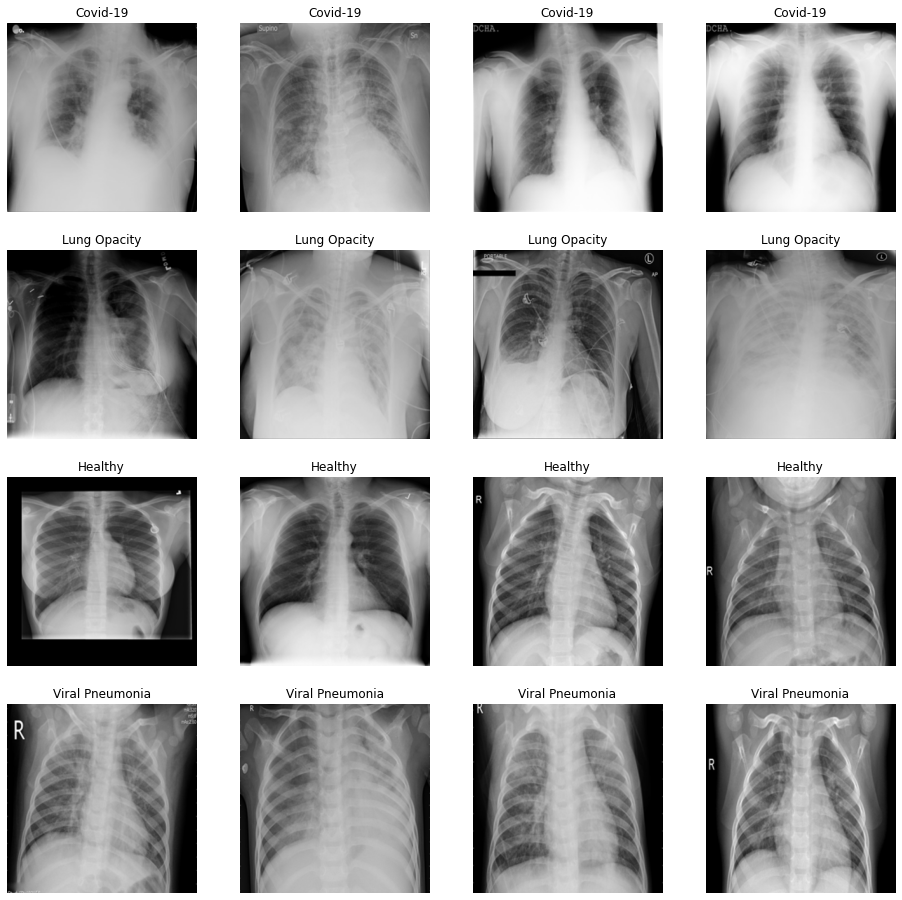

In [9]:
# collect 4 images from each class
sample_imgs = []
classes = covidData.Class.unique()
for i in classes:
    for j in range(4):
        sample_imgs.append(cv2.imread(covidData[covidData.Class == i].iloc[j, 1]))
        
# plot each image from sample_imgs
plt.figure(figsize=(16,16))

for i in range(0,16):
    plt.subplot(4, 4, i+1)
    plt.imshow(sample_imgs[i])
    plt.axis('off')
    plt.title(classes[i//4])

In [10]:
img = cv2.imread(covidData.iloc[0,1])
# shape of the image
img.shape
# 299 by 299 pixels

(299, 299, 3)

In [11]:
covidData['image'] = covidData['path'].map(lambda x : np.array(Image.open(x).resize((75,75))))

In [12]:
covidData = covidData[['image_id', 'path', 'target', 'image', 'Class']] # rearranging the columns

In [13]:
mean_vals, max_vals, min_vals, std_vals = [],[],[],[]

for i in range(covidData.shape[0]):
    mean_vals.append(covidData['image'][i].mean())
    max_vals.append(covidData['image'][i].max())
    min_vals.append(covidData['image'][i].min())
    std_vals.append(np.std(covidData['image'][i]))
    
raw_df = covidData.loc[:, ['image']]
raw_df['max'] = max_vals
raw_df['min'] = min_vals
raw_df['mean'] = mean_vals
raw_df['std'] = std_vals
raw_df['Class'] = covidData.loc[:,'Class']

In [14]:
raw_df.head()

,image,max,min,mean,std,Class
0,"[[15, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",214,0,145.912889,51.656605,Covid-19
1,"[[129, 125, 123, 121, 119, 117, 114, 104, 104,...",226,0,141.363911,40.387871,Covid-19
2,"[[11, 0, 0, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0...",254,0,152.815644,73.488715,Covid-19
3,"[[42, 39, 38, 42, 38, 35, 31, 26, 24, 24, 24, ...",251,0,162.750222,76.065224,Covid-19
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0,...",217,0,129.909867,65.717501,Covid-19


Text(0.5, 1.0, 'Image color mean value distribution')

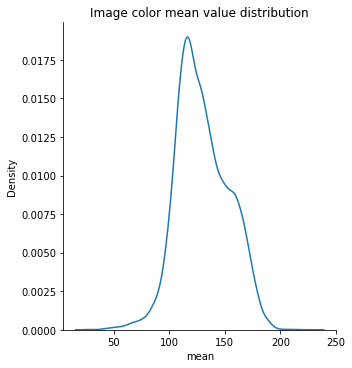

In [15]:
ax = sns.displot(data = raw_df, x = 'mean', kind="kde")
plt.title('Image color mean value distribution')

[]

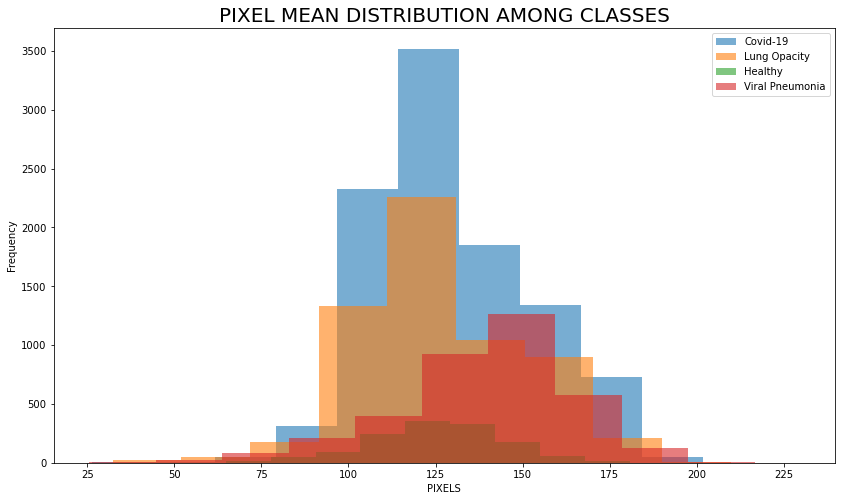

In [16]:
raw_df[raw_df.Class=='Healthy']['mean'].plot(kind='hist',
                                             figsize=(14,8),
                                             alpha=0.6)

raw_df[raw_df.Class=='Lung Opacity']['mean'].plot(kind='hist',alpha=0.6)

raw_df[raw_df.Class=='Viral Pneumonia']['mean'].plot(kind='hist', alpha=0.6)

raw_df[raw_df.Class=='Covid-19']['mean'].plot(kind='hist', alpha=0.6)


plt.xlabel('PIXELS')
plt.title('PIXEL MEAN DISTRIBUTION AMONG CLASSES', fontsize=20)
plt.legend(raw_df.Class.unique())
plt.plot()

Text(0.5, 1.0, 'Image color max value distribution by class')

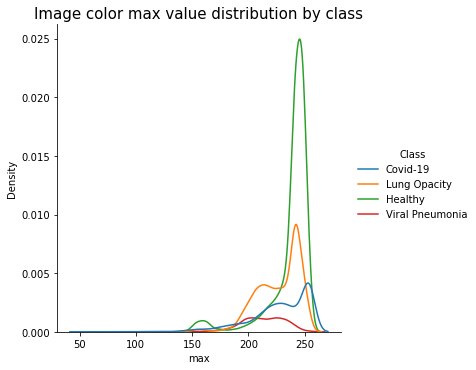

In [17]:
ax = sns.displot(data = raw_df, x = 'max', kind="kde", hue='Class')
plt.title('Image color max value distribution by class',fontsize=15)

Text(0.5, 1.0, 'Image color max value distribution by class')

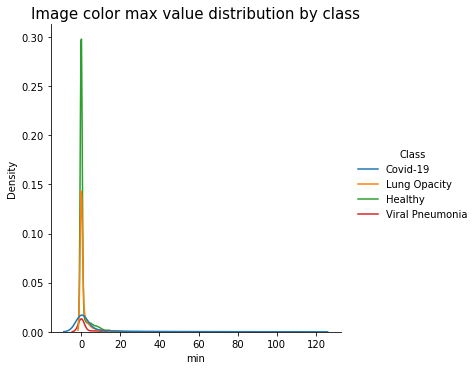

In [18]:
ax = sns.displot(data = raw_df, x = 'min', kind="kde", hue='Class')
plt.title('Image color max value distribution by class',fontsize=15)

Text(0.5, 1.0, 'Mean and Standard Deviation of Image Samples')

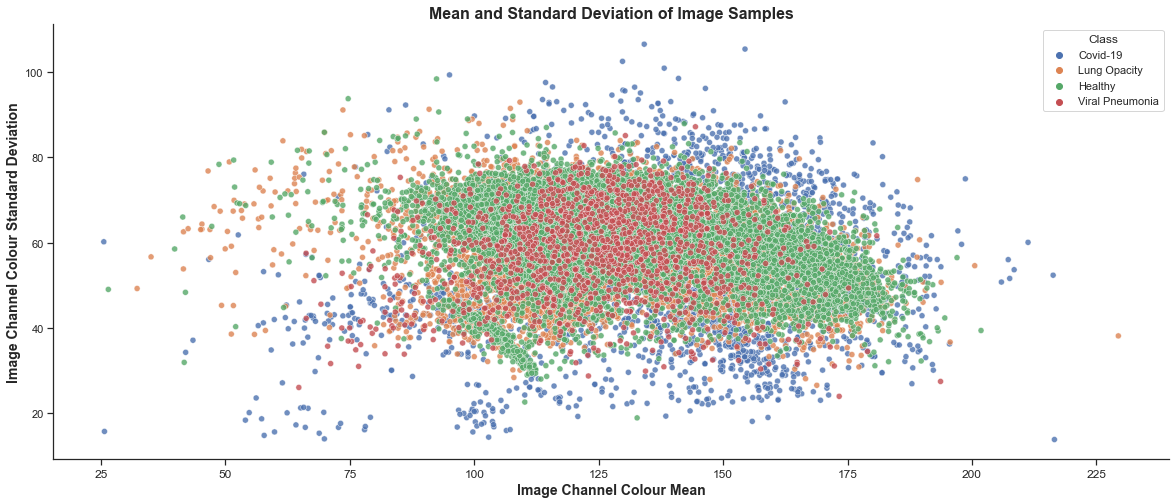

In [19]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=raw_df, x="mean", y=raw_df['std'], hue = 'Class',alpha=0.8)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold')

# It is evident from the histogram and this scatter plot that COVID samples tend to have a slightly higher mean and standard deviation from Non-Covid samples

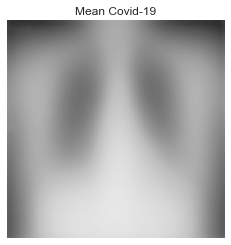

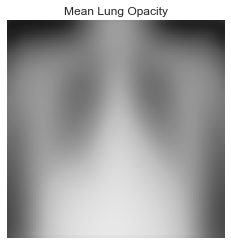

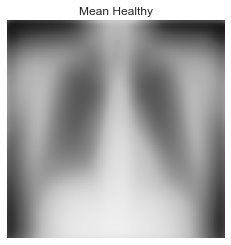

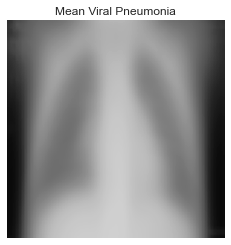

In [20]:
# Plotting the average image of each class

def find_mean_img(full_mat, title):
    # calculate the average
    mean_img = np.zeros((75,75))
    for i in range(full_mat.shape[0]):
        if full_mat.iloc[i, 0].shape == (75,75):            # About a 100 images have shape (75,75,3) instead of (75,75). Strage.     
            mean_img += full_mat.iloc[i,0]                  # I didn't know what to do about it, so I skipped them while calculating the mean_img
    mean_img /= full_mat.shape[0]
    # plot the average image
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Mean {title}')
    plt.axis('off')
    plt.show()
    return mean_img

for i in raw_df.Class.unique():
    find_mean_img(raw_df[raw_df.Class == i][['image']], i)

In [21]:
# I don't really see much difference except maybe the average Non-Covid lungs looks slightly larger and well defined than average Covid lungs
# The images with these index in covidData have shape (75,75,3) instead of (75,75). Strange
for i in range(raw_df.shape[0]):
    if raw_df['image'][i].shape!=(75,75):
        print(i, end=', ')

19827, 19828, 19841, 19915, 19959, 19993, 19994, 20212, 20214, 20223, 20224, 20231, 20238, 20245, 20257, 20260, 20268, 20273, 20280, 20281, 20282, 20283, 20284, 20287, 20301, 20303, 20307, 20308, 20309, 20316, 20330, 20343, 20369, 20386, 20390, 20391, 20392, 20399, 20409, 20410, 20412, 20415, 20419, 20423, 20425, 20428, 20437, 20448, 20460, 20470, 20474, 20480, 20481, 20483, 20486, 20487, 20489, 20490, 20497, 20498, 20509, 20510, 20525, 20526, 20531, 20532, 20534, 20537, 20540, 20550, 20560, 20564, 20565, 20581, 20605, 20631, 20632, 20634, 20636, 20657, 20668, 20696, 20701, 20704, 20705, 20706, 20707, 20734, 20736, 20737, 20749, 20751, 20753, 20761, 20762, 20773, 20775, 20779, 20780, 20782, 20783, 20792, 20803, 20819, 20823, 20825, 20880, 20883, 20889, 20891, 20892, 20904, 20908, 20911, 20914, 20924, 20933, 20935, 20948, 20951, 20961, 20963, 20973, 21006, 21048, 21052, 21058, 21075, 21078, 21079, 21087, 21116, 21128, 21129, 21133, 21134, 21142, 21145, 21146, 21163, 

In [22]:
path = "C:\\Users\\kumar\\Desktop\\Avatar_Assignment\\COVID-19_Radiography_Dataset"

classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
num_classes = len(classes)
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)

train_gen = train_datagen.flow_from_directory(directory=path,
                                             target_size=(299, 299),
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="grayscale")
test_gen = test_datagen.flow_from_directory(directory=path,
                                             target_size=(299, 299),
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=False, classes=classes,
                                             batch_size=batch_size,
                                             color_mode="grayscale")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [23]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='Same', input_shape=(299, 299, 1)))
model.add(BatchNormalization())

################

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#################

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#################

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 299, 299, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 299, 299, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 299, 299, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 299, 299, 64)     256       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 149, 149, 64)     0         
 ooling2D)                                                       
                                                        

In [25]:
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[Recall()])

C:\Users\kumar\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
#Model params
epochs=80

#callback
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=100, monitor='val_loss', mode='min')

callbacks_list = [learning_rate_reduction, early_stopping_monitor]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen) // batch_size,
                    validation_steps=len(test_gen) // batch_size,
                    validation_data=test_gen, epochs=epochs, callbacks=[callbacks_list])

Epoch 1/80
66/66 [==============================] - 553s 8s/step - loss: 1.6418 - recall: 0.3324 - val_loss: 0.7382 - val_recall: 0.5000 - lr: 0.0020
Epoch 2/80
66/66 [==============================] - 526s 8s/step - loss: 1.2677 - recall: 0.4096 - val_loss: 0.9640 - val_recall: 0.1367 - lr: 0.0020
Epoch 3/80
66/66 [==============================] - 504s 8s/step - loss: 1.1074 - recall: 0.4688 - val_loss: 1.2696 - val_recall: 0.0000e+00 - lr: 0.0020
Epoch 4/80
66/66 [==============================] - 532s 8s/step - loss: 1.1327 - recall: 0.4536 - val_loss: 1.4715 - val_recall: 0.0000e+00 - lr: 0.0020
Epoch 5/80
66/66 [==============================] - 511s 8s/step - loss: 1.0558 - recall: 0.4763 - val_loss: 1.0970 - val_recall: 0.1719 - lr: 0.0020
Epoch 6/80
66/66 [==============================] - 482s 7s/step - loss: 1.0960 - recall: 0.4574 - val_loss: 1.5010 - val_recall: 0.1250 - lr: 0.0020
Epoch 7/80
66/66 [==============================] - 489s 7s/step - loss: 1.0726 - recall: 0.

In [32]:
y_pred = model.predict(test_gen)

In [33]:
history.history.keys()

dict_keys(['loss', 'recall', 'val_loss', 'val_recall', 'lr'])

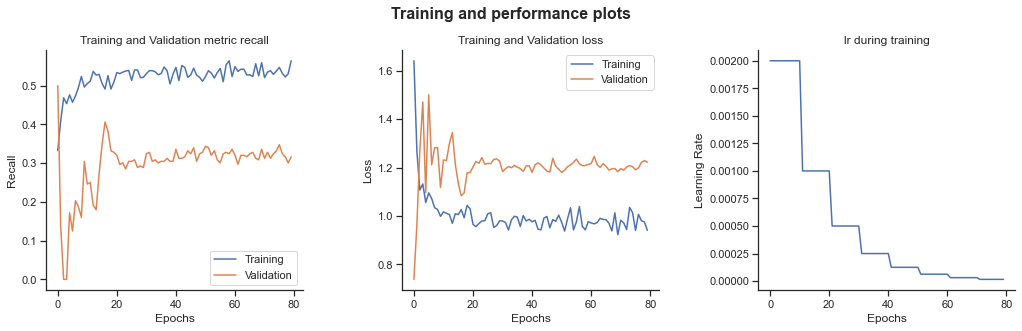

In [34]:
fig, axarr = plt.subplots(1,3, figsize=(15,5), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

historyDF = pd.DataFrame.from_dict(history.history)
ax = sns.lineplot(x = historyDF.index, y = history.history['recall'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_recall'], ax=axarr[0], label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x = historyDF.index, y = history.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = history.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')

ax = sns.lineplot(x = historyDF.index, y = history.history['lr'], ax=axarr[2]);
ax.set_ylabel('Learning Rate')

axarr[0].set_title('Training and Validation metric recall')
axarr[1].set_title('Training and Validation loss')
axarr[2].set_title('lr during training')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

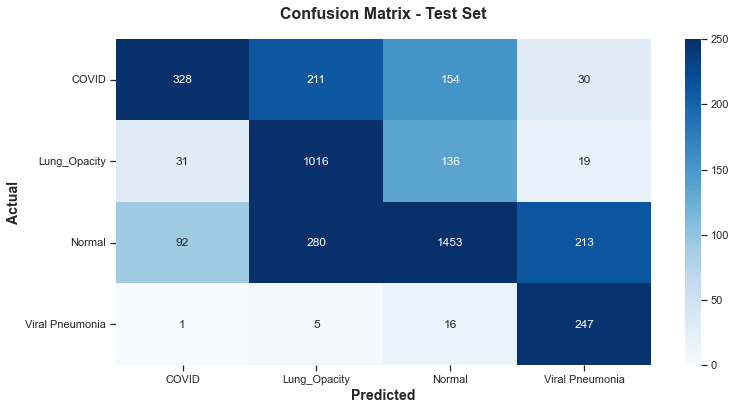

In [35]:
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))

y_true=test_gen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

**Overall Results**
Accuracy Result: 71.93%
Precision Result: 67.72%
Recall Result: 73.25%
F-Score Result: 67.68%


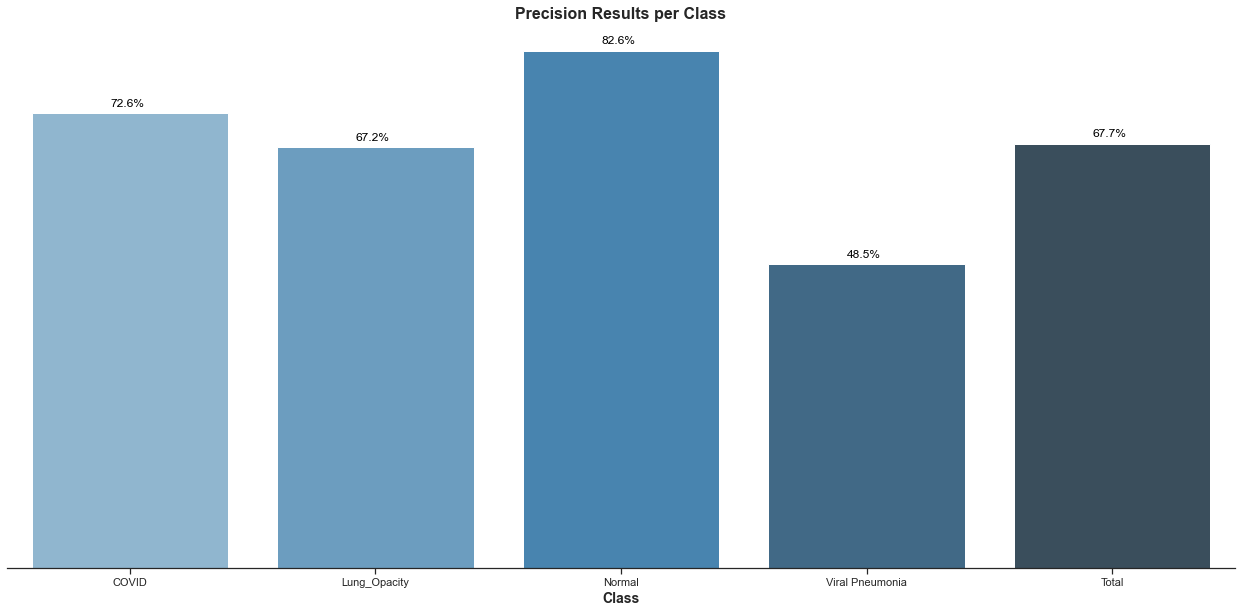

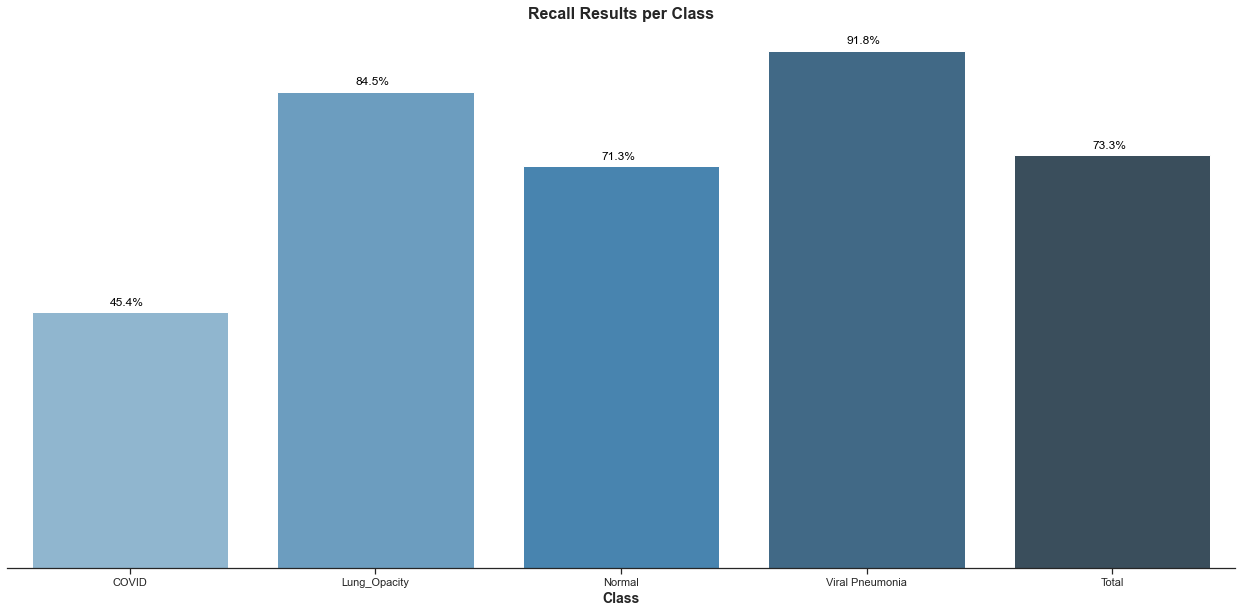

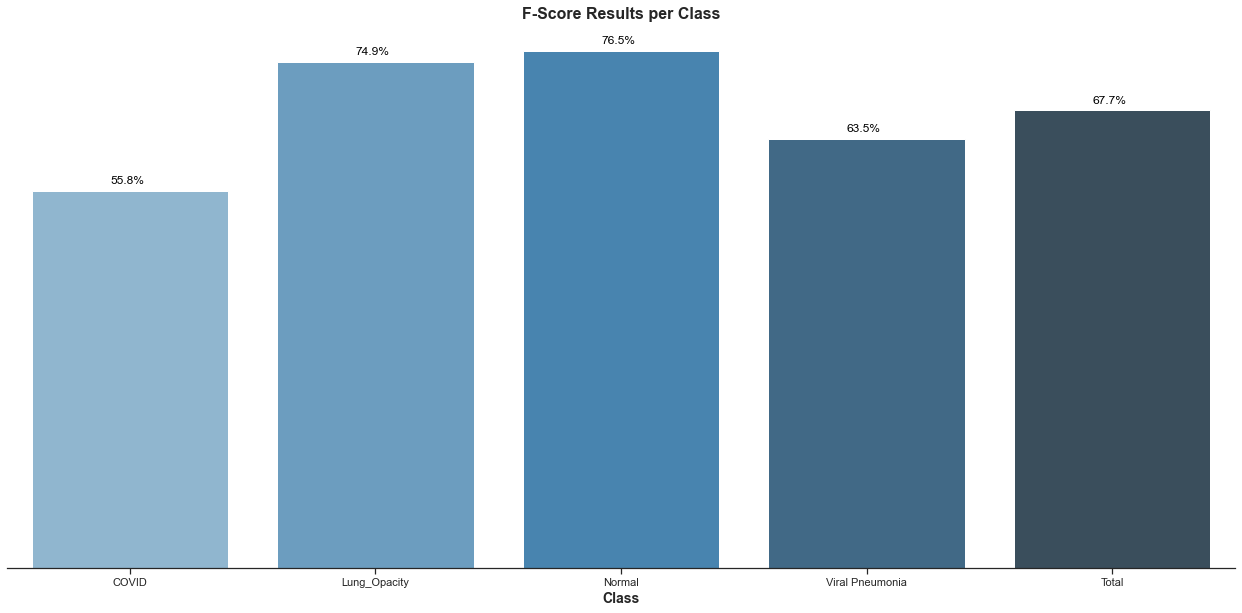

In [36]:
acc = accuracy_score(y_true, predictions)

results_all = precision_recall_fscore_support(y_true, predictions, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division=1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
        
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[4,2]*100))#F-Score of the whole Dataset